Dataset link: https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews/data

In [1]:
import os
import re
import shutil
import kagglehub
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

/home/divyanshu/personal/product_id_classifier/.cls_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download and save raw file from Kaggle
raw_path = kagglehub.dataset_download("arhamrumi/amazon-product-reviews")
files = os.listdir(raw_path)
csv_file = [f for f in files if f.endswith('.csv')][0]
full_csv_path = os.path.join(raw_path, csv_file)

100%|██████████| 115M/115M [00:33<00:00, 3.59MB/s] 

Extracting files...


# Data strategy

Data distribution: Product IDs are generally alpha-numeric-special character part numbers of varying lengths, which often follow patterns within an organization, and may or may not contain product level information. No single standard exists to create such an ID, and thus the available data is imbalanced. To replicate the same, I collect Amazon Product IDs as well as User IDs (to mimic differences in pattern across IDs across organizations) from the above downloaded Kaggle dataset and use the given product IDs as the positive samples. Negative samples will be obtained from the rest of the columns (excluding product IDs), for the purpose of training the classifier and testing the system. The dataset will be divided in three parts: Test set, VAE set, CLS (classifier) set.

1. Test set: 10% of the entire positive samples are reserved for testing. Negative samples will be added from the rest of the columns (excluding product IDs), in an equal proportion.

2. VAE set: 70% of the entire positive samples will be used for pre-training the VAE. Of this, 20% will be reserved for evaluation. Negative samples will be added to the evaluation subset.

3. CLS set: 20% of the entire positive samples will be used for training the classifier. Of this, 20% will be reserved for evaluation. Negative samples will be added to both the training and the evaluation subsets, to mimic real word balanced classification data. (Given the smaller amount required for the classifier head, such data can be manually generated).

In [3]:
# Prepare the dataset
print("Processing data...")
df = pd.read_csv(full_csv_path)
df.head()

Processing data...


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# EDA

In [4]:
# Checking distribution: length, alpha-num-special characters distribution, unhandled unicodes, etc.

In [5]:
cols_to_analyze = ['ProductId', 'UserId', 'Time', 'Summary']

In [6]:
# Basic profiling first
def profile_data(df, columns):
    profile = []
    
    for col in columns:
        total_count = len(df)
        null_count = df[col].isnull().sum()
        unique_count = df[col].nunique()
        
        # Checking for empty strings
        empty_str_count = (df[col].astype(str).str.strip() == "").sum()
        
        null_perc = (null_count / total_count) * 100
        unique_perc = (unique_count / total_count) * 100
        profile.append({
            'Column': col,
            'Total Rows': total_count,
            'Null Count': null_count,
            'Null %': f"{null_perc:.2f}%",
            'Empty/Blank': empty_str_count,
            'Unique Count': unique_count,
            'Cardinality %': f"{unique_perc:.2f}%",
            'Data Type': df[col].dtype
        })
    return pd.DataFrame(profile)

stats_df = profile_data(df, cols_to_analyze)

print(stats_df)

      Column  Total Rows  Null Count Null %  Empty/Blank  Unique Count  \
0  ProductId      568454           0  0.00%            0         74258   
1     UserId      568454           0  0.00%            0        256059   
2       Time      568454           0  0.00%            0          3168   
3    Summary      568454          27  0.00%            0        295742   

  Cardinality % Data Type  
0        13.06%    object  
1        45.04%    object  
2         0.56%     int64  
3        52.03%    object  


--- Analyzing Column: ProductId ---
               count       mean       std   min   25%   50%   75%   max
length      568454.0  10.000000  0.000000  10.0  10.0  10.0  10.0  10.0
alphabetic  568454.0   5.355285  1.089396   0.0   5.0   5.0   6.0   7.0
numeric     568454.0   4.644715  1.089396   3.0   4.0   5.0   5.0  10.0
special     568454.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.0
non_ascii   568454.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.0


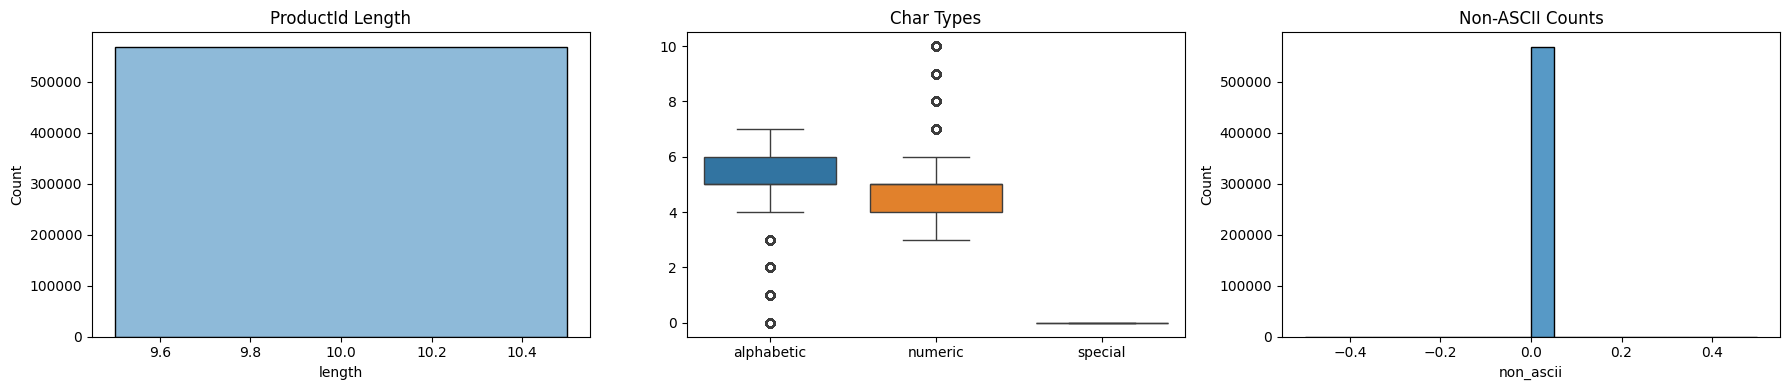

--- Analyzing Column: UserId ---
               count       mean       std   min   25%   50%   75%   max
length      568454.0  13.740834  0.479500  10.0  13.0  14.0  14.0  21.0
alphabetic  568454.0   9.651903  1.560994   3.0   9.0  10.0  11.0  15.0
numeric     568454.0   4.086426  1.623270   0.0   3.0   4.0   5.0  16.0
special     568454.0   0.002505  0.070738   0.0   0.0   0.0   0.0   2.0
non_ascii   568454.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.0


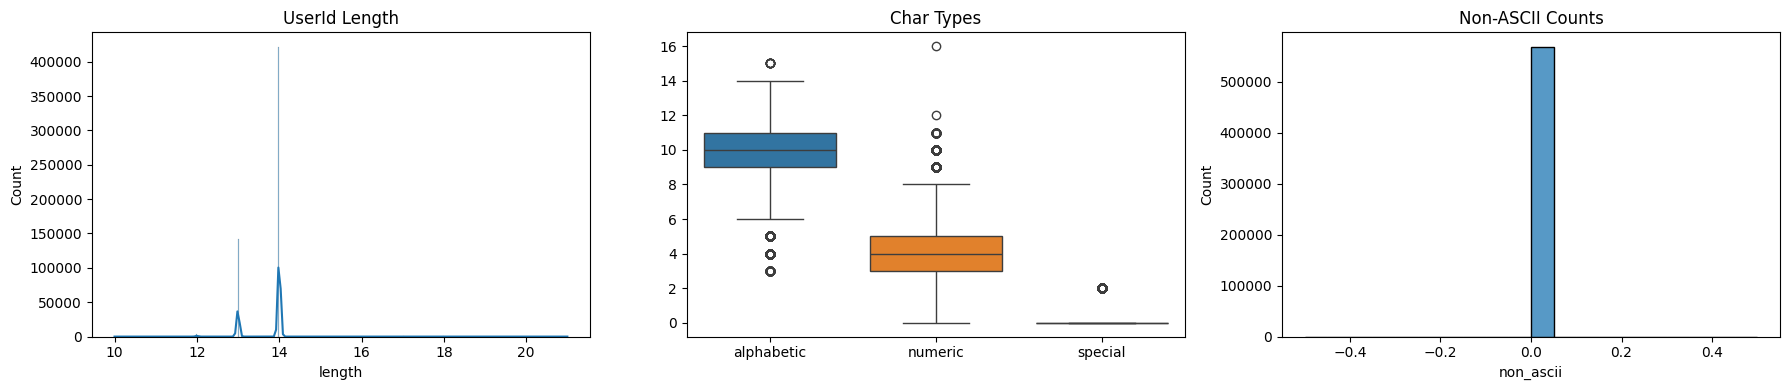

--- Analyzing Column: Time ---
               count      mean       std  min   25%   50%   75%   max
length      568454.0  9.999923  0.008798  9.0  10.0  10.0  10.0  10.0
alphabetic  568454.0  0.000000  0.000000  0.0   0.0   0.0   0.0   0.0
numeric     568454.0  9.999923  0.008798  9.0  10.0  10.0  10.0  10.0
special     568454.0  0.000000  0.000000  0.0   0.0   0.0   0.0   0.0
non_ascii   568454.0  0.000000  0.000000  0.0   0.0   0.0   0.0   0.0


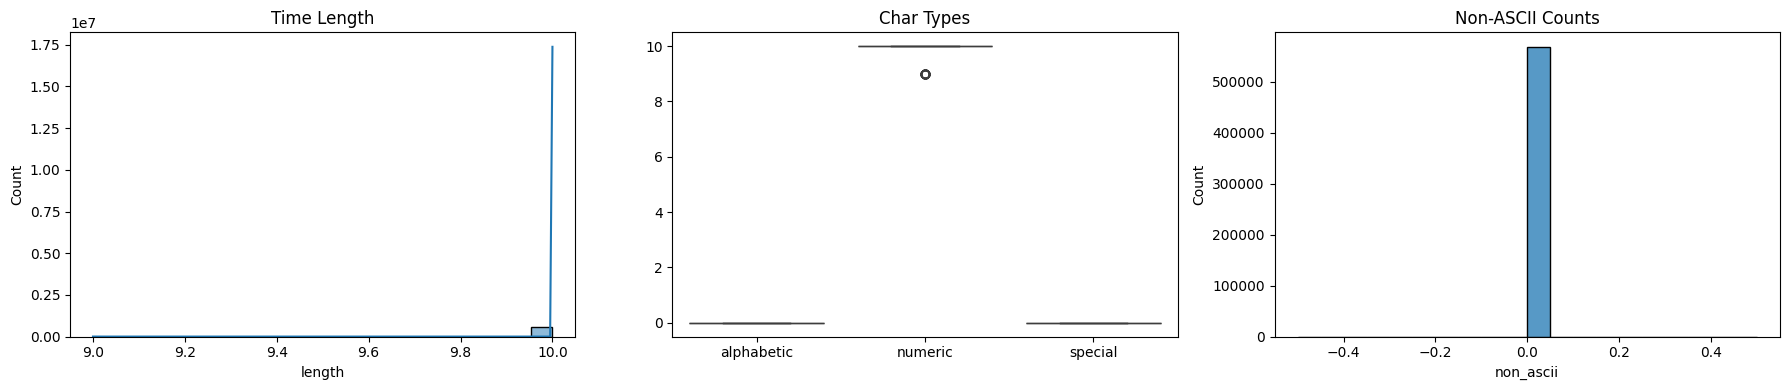

--- Analyzing Column: Summary ---
               count       mean        std  min   25%   50%   75%    max
length      568454.0  23.445887  14.028439  1.0  13.0  20.0  30.0  128.0
alphabetic  568454.0  19.368473  11.087085  0.0  11.0  17.0  25.0  108.0
numeric     568454.0   0.046806   0.380095  0.0   0.0   0.0   0.0   60.0
special     568454.0   0.902295   1.461614  0.0   0.0   0.0   1.0   72.0
non_ascii   568454.0   0.000132   0.029088  0.0   0.0   0.0   0.0   18.0


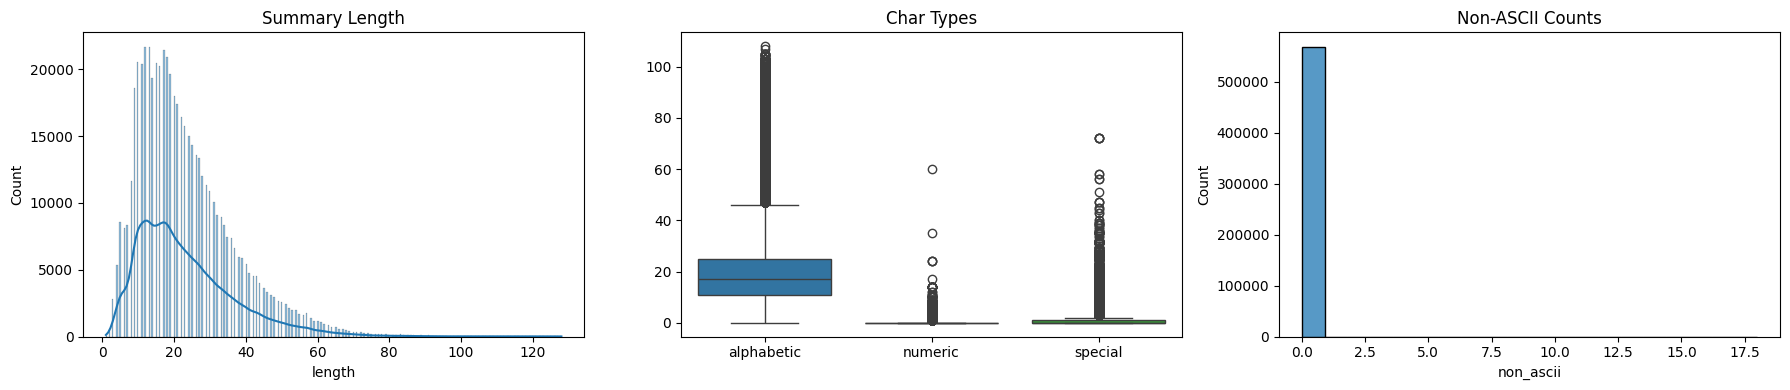

In [7]:
def get_text_stats(df, column):
    stats = pd.DataFrame()
    
    # 1. Length Distribution
    stats['length'] = df[column].astype(str).apply(len)
    
    # 2. Character Distributions (Regex)
    stats['alphabetic'] = df[column].astype(str).apply(lambda x: len(re.findall(r'[a-zA-Z]', x)))
    stats['numeric'] = df[column].astype(str).apply(lambda x: len(re.findall(r'[0-9]', x)))
    stats['special'] = df[column].astype(str).apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)))
    
    # 3. Unhandled/Non-ASCII Unicodes
    stats['non_ascii'] = df[column].astype(str).apply(lambda x: len(re.findall(r'[^\x00-\x7F]', x)))
    return stats


for col in cols_to_analyze:
    print(f"--- Analyzing Column: {col} ---")
    data_stats = get_text_stats(df, col)
    
    # Display Summary Stats
    print(data_stats.describe().T)
    
    # Plotting Distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.histplot(data_stats['length'], kde=True, ax=axes[0]).set_title(f'{col} Length')
    sns.boxplot(data=data_stats[['alphabetic', 'numeric', 'special']], ax=axes[1]).set_title('Char Types')
    sns.histplot(data_stats['non_ascii'], bins=20, ax=axes[2]).set_title('Non-ASCII Counts')
    plt.tight_layout()
    plt.show()

Analysis so far: Data set looks clean (Kaggle!), no missing/null/empty values. IDs are alpha-numeric, summary has some special characters which may need to be encoded correctly (vocabulary creation for char level encoding) and some non-ASCII unicodes that need to be removed, repeat entries in IDs will need to be handled before splitting.

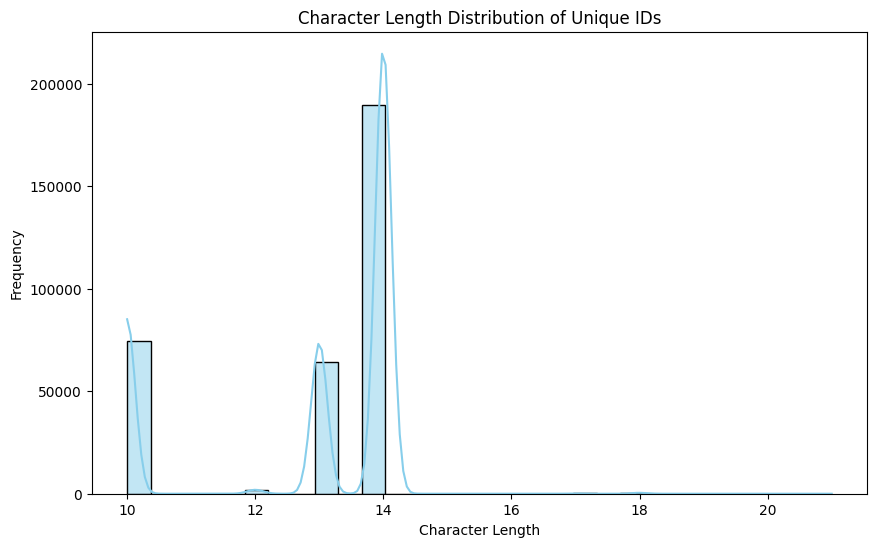

In [8]:
# Combine ID columns to check length distribution

all_ids = set(df['ProductId'].astype(str).tolist() + df['UserId'].astype(str).tolist())
lengths = [len(str(i)) for i in all_ids]

len_dist = pd.Series(lengths)
plt.figure(figsize=(10, 6))
sns.histplot(len_dist, kde=True, color='skyblue', bins=30)
plt.title('Character Length Distribution of Unique IDs')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

Majority of the data lies between 10-14 characters. Since the VAE requires fixed length inputs, I will set the character length at 14. To normalize all inputs to this length, I can pad and truncate wherever needed.

As a sanity check, I remove all inputs below char length 10 (to avoid training the model on too many padded tokens). This will be applied during inference as well.

In [9]:
# Check all special characters across all columns, not all should be trained on

print("In ID columns:", set(re.findall(r'[^a-zA-Z0-9\s]', "".join(df[["ProductId", "UserId"]].astype(str).stack().unique()))))
print("In summary & time columns:", set(re.findall(r'[^a-zA-Z0-9\s]', "".join(df[["Time", "Summary"]].astype(str).stack().unique()))))
print("Non-ASCII characters:", set(re.findall(r'[^\x00-\x7F]', "".join(df[cols_to_analyze].astype(str).stack().unique()))))

In ID columns: {'#', '-'}
In summary & time columns: {'.', ']', 'û', '/', '{', '#', 'Ý', '»', '$', '©', 'å', '+', ';', '_', '?', '[', ',', '£', '}', 'â', '"', '-', '\\', '%', "'", '(', '®', ':', '«', '`', '^', '|', '&', 'Ã', '>', '@', '*', 'ç', '!', ')', '~', '½', 'Å', '='}
Non-ASCII characters: {'»', 'â', '©', 'û', 'å', 'Ã', 'ç', 'Å', '®', '«', '½', '£', 'Ý'}


Since the IDs (positive samples) seem to have valid special characters that could actually be part of product IDs, I let the negative samples (summary & time) contain some out of domain special characters that the classifier can be trained with. I manually clear the non-ASCII characters to ensure encoding belongs to the same vocabulary, and mark it as unseen characters for both the VAE and classifier.

# Preprocessing

In [10]:
# Positive samples: Apply 10 - 14 characters limit
truncated_ids = [s[:14] if len(s) > 14 else s for s in all_ids]
final_ids = [s for s in truncated_ids if len(s) >= 10]

print("Number of positive samples:", len(final_ids))

Number of positive samples: 330317


In [11]:
# Negative samples: Remove non-ASCII characters, apply length limits
all_unique_values = df[cols_to_analyze].astype(str).stack().unique()
non_ascii_found = set(re.findall(r'[^\x00-\x7F]', "".join(all_unique_values)))
mask = df[cols_to_analyze].astype(str).apply(lambda x: x.str.contains(r'[^\x00-\x7F]')).any(axis=1)
wrong_chars = df[mask].copy()
all_bad_text = "".join(wrong_chars[['Summary', 'Time']].astype(str).stack())
# Catch and store removed chars for inference
found_chars_list = re.findall(r'[^\x00-\x7F]', all_bad_text)
compressed_wrong_chars = pd.DataFrame({
    'found_chars': list(set(found_chars_list))
})


df_clean = df[~mask].copy()
clean_pool = df_clean[cols_to_analyze].astype(str).stack().unique()

truncated_set = set(s[:14] for s in clean_pool)
negative_samples = [s for s in truncated_set if len(s) >= 10]

print("Number of negative samples:", len(negative_samples))

Number of negative samples: 540274


# Create splits

In [12]:
os.makedirs('../data', exist_ok=True)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [13]:
def generate_synthetic_negatives(base_negatives, target_count):
    """
    Ensures 50% are sampled from real noise (Time/Summary) 
    and 50% are synthetically manufactured with mixed types and special chars.
    """
    half_count = target_count // 2
    other_half = target_count - half_count

    standard_negs = random.sample(list(set(base_negatives)), min(len(base_negatives), half_count))
    special_chars = "!@#$%^&*()-_=+"
    synthetic = []
    
    while len(synthetic) < other_half:
        s1 = random.choice(base_negatives)
        s2 = random.choice(base_negatives)
        pivot = len(s1) // 2
        combined = s1[:pivot] + s2[pivot:]
        char_list = list(combined)
        for _ in range(random.randint(1, 3)):  # Inject 1-3 noisy chars
            idx = random.randint(0, len(char_list) - 1)
            noise_type = random.random()
            
            if noise_type < 0.4: # 40% chance of adding a digit
                char_list[idx] = random.choice(string.digits)
            elif noise_type < 0.7: # 30% chance of adding a special char
                char_list[idx] = random.choice(special_chars)
            # 30% chance stays as is (original string char)
            
        final_str = "".join(char_list)
        
        # Meet length criterion
        target_len = random.randint(10, 14)
        final_str = final_str[:target_len]
        if len(final_str) >= 10:
            synthetic.append(final_str)
            
    return standard_negs + synthetic

In [14]:
# Split Positives: 10% Test, 70% VAE, 20% CLS (Rule logic same as discussed in data strategt section)
pos_test, pos_remaining = train_test_split(final_ids, test_size=0.9, random_state=SEED)
pos_cls, pos_vae = train_test_split(pos_remaining, test_size=(0.7/0.9), random_state=SEED)

In [15]:
# 1. Generate test set (10% pos samples, 1:1 neg samples)
neg_for_test = generate_synthetic_negatives(negative_samples, len(pos_test))
test_set = pd.concat([
    pd.DataFrame({'input': pos_test, 'is_pd_id': 'yes', 'split': 'test'}),
    pd.DataFrame({'input': neg_for_test, 'is_pd_id': 'no', 'split': 'test'})
]).sample(frac=1, random_state=SEED)

In [16]:
# 2. Generate vae set (70% pos samples in train, neg samples only in eval)
vae_train_pos, vae_eval_pos = train_test_split(pos_vae, test_size=0.2, random_state=SEED)
neg_for_vae_eval = generate_synthetic_negatives(negative_samples, len(vae_eval_pos))

vae_train_df = pd.DataFrame({'input': vae_train_pos, 'is_pd_id': 'yes', 'split': 'train'})
vae_eval_df = pd.concat([
    pd.DataFrame({'input': vae_eval_pos, 'is_pd_id': 'yes', 'split': 'eval'}),
    pd.DataFrame({'input': neg_for_vae_eval, 'is_pd_id': 'no', 'split': 'eval'})
])
vae_set = pd.concat([vae_train_df, vae_eval_df]).sample(frac=1, random_state=SEED)

In [17]:
# 3. Generate cls set (20% pos samples, 1:1 neg samples in both train and eval)
cls_train_pos, cls_eval_pos = train_test_split(pos_cls, test_size=0.2, random_state=SEED)
neg_for_cls_train = generate_synthetic_negatives(negative_samples, len(cls_train_pos))
neg_for_cls_eval = generate_synthetic_negatives(negative_samples, len(cls_eval_pos))

cls_train_df = pd.concat([
    pd.DataFrame({'input': cls_train_pos, 'is_pd_id': 'yes', 'split': 'train'}),
    pd.DataFrame({'input': neg_for_cls_train, 'is_pd_id': 'no', 'split': 'train'})
])
cls_eval_df = pd.concat([
    pd.DataFrame({'input': cls_eval_pos, 'is_pd_id': 'yes', 'split': 'eval'}),
    pd.DataFrame({'input': neg_for_cls_eval, 'is_pd_id': 'no', 'split': 'eval'})
])
cls_set = pd.concat([cls_train_df, cls_eval_df]).sample(frac=1, random_state=SEED)

In [18]:
test_set[test_set['is_pd_id'] == 'yes'].head(), test_set[test_set['is_pd_id'] == 'no'].head()

(                input is_pd_id split
 9020   A2QNX5FB904HTA      yes  test
 31872  A1S650Z5HGZVJ6      yes  test
 14936      B001L6FPTI      yes  test
 11634  A3DO44X7IZNPI6      yes  test
 31546  A2FX74YFX312X7      yes  test,
                 input is_pd_id split
 24454  AM6LMC9JJG4023       no  test
 16198  My Cats will n       no  test
 16734    Also S97W1YI       no  test
 30512      B008%7=lid       no  test
 9246   A1BCDQAWWZ4JT0       no  test)

In [19]:
vae_set[vae_set['is_pd_id'] == 'yes'].head(), vae_set[vae_set['is_pd_id'] == 'no'].head()

(                input is_pd_id  split
 30505  A2SGDYZHVBU3KH      yes   eval
 73487  A1WIFELUBSBQIC      yes  train
 71408  A2SB88JO0T8AI4      yes  train
 61865  A2AOC8S3W77E0Q      yes  train
 75638  A34O0980YBRQMS      yes  train,
                 input is_pd_id split
 32670    A3S08UFLG5-W       no  eval
 24730      AHG40KA8Z3       no  eval
 8089   Fast Shipment        no  eval
 23308  6he ca3E YUMMM       no  eval
 2620   A1N2WEWGQHD0RS       no  eval)

In [20]:
cls_set[cls_set['is_pd_id'] == 'yes'].head(), cls_set[cls_set['is_pd_id'] == 'no'].head()

(                input is_pd_id  split
 8326       B000B9HU6W      yes   eval
 47082      B006GPBQPQ      yes  train
 44701  A1CW9R4ROHVSYH      yes  train
 38478   AVPIZKM3L3G74      yes  train
 35485  A2YSXGDM2GVZZE      yes  train,
                 input is_pd_id  split
 26795    A3B12JZtradi       no  train
 27684    JalapenT3S(X       no  train
 27994  A15KBOFl aboar       no  train
 39591    ^K9QQM4W9NC9       no  train
 39733   This isAWMDC7       no  train)

In [21]:
compressed_wrong_chars.head()

,found_chars
0,»
1,â
2,©
3,û
4,å


In [22]:
# Save and clean up
test_set.to_csv('../data/test_set.csv', index=False)
vae_set.to_csv('../data/vae_set.csv', index=False)
cls_set.to_csv('../data/cls_set.csv', index=False)
compressed_wrong_chars.to_csv('../data/wrong_chars.csv', index=False)

shutil.rmtree(raw_path)

print("Preprocessed data saved to data/ and raw cache deleted.")

Preprocessed data saved to data/ and raw cache deleted.
